In [1]:
### Imports ###
import pyross.tsi as pyrosstsi
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
### Model Init from SIR class ###

# Population
N = int(1e3) # full population size
M = 1 # just one age group to begin
Ni = np.array([N]) # Array of age group sizes

# Contact Matrix
CM = np.zeros((M, M))
def contactMatrix(t):
    CM[0,0] = 1
    return CM

# Time since infection: cut-off + discretisation
tsi_max = 50 # days
dtsi = 1/5. # days
kI = int(tsi_max/dtsi)+1
dt = dtsi
Tf = 200 # days
Nf = int(Tf/dt)+1

# beta
def beta_fun(tsi, beta0, tsi_max):
    if tsi<tsi_max:
        return beta0
    else:
        return None
    
def beta_vec(beta0, kI, tsi_max):
    beta = []
    dtsi = tsi_max/float(kI)
    for k in range(kI):
        beta.append(beta_fun(k*dtsi, beta0, tsi_max))
    return beta

beta0 = 0.2
beta = np.zeros((M,kI))
for i in range(M):
    beta[i,:] = beta_vec(beta0, kI, tsi_max)

# gamma(tsi):
def gamma_fun(tsi, g0, tsi_max):
    if g0>0:
        if tsi<tsi_max:
            return g0/(1-np.exp(-g0*(tsi_max-tsi))) # truncated exponential
        else:
            return None
    else:
        return 0

def gamma_vec(g0, kI, tsi_max):
    gI = []
    dtsi = tsi_max/float(kI)
    for k in range(kI):
        gI.append(gamma_fun(dtsi*k, g0, tsi_max))
    return gI
    
g0 = 1/10. # day^{-1}
gamma = np.zeros((M,kI))
for i in range(M):    
    gamma[i,:] = gamma_vec(g0, kI, tsi_max)

# Sort parameters into a dictionary
parameters = {'beta': beta,
              'gI': gamma,
              'kI': kI,
              'M': M}

### Initial Conditions ###

# 4 infectives at t=0
I0 = np.zeros((M, kI))
I0_init_list = [(1, 0), (2, tsi_max/10.) ,(1, tsi_max/2.)] # (number of infectives, tsi)
for tup in I0_init_list:
    k = int(tup[1]/dtsi)
    I0[0,k] = tup[0]

# N-4 susceptibles at t=0
S0 = np.zeros(M)
S0[0] = N - np.sum(I0[0,:]) # 

model = pyrosstsi.deterministic.SIR(parameters, M, Ni)

In [3]:
### Parameters ###
dtsi = 1/10.

# Time since infection: cut-off + discretisation
tsi_max = 50 # days
dtsi = 1/5. # days

# beta
beta = beta_vec(beta0, kI, tsi_max)

# gamma
gI = gamma_vec(g0, kI, tsi_max)

### Initial condition ###
# We just rescale the initial condition from stochastic
i0 = np.zeros(kI)
for tup in I0_init_list:
    k = int(tup[1]/dtsi)
    i0[k] = (tup[0]/float(N))/dtsi

s0 = S0[0]/float(N)

### Run ###
s_det_traj, i_det_traj = model.simulate(s0, i0, beta, gI, kI, tsi_max, Tf)

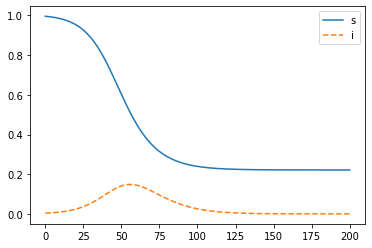

In [4]:
### PLOT ###
times = np.linspace(0, Tf, len(s_det_traj))
iagg_det_traj = []
# iagg_detold_traj = []
# aggregated infected pop
for t in range(len(s_det_traj)):
    iagg_det_traj.append(np.sum(i_det_traj[t]*dtsi))
#     iagg_detold_traj.append(np.sum(i_detold_traj[t])*dtsi)
    
plt.plot(times, s_det_traj, label='s')
# plt.plot(times, s_detold_traj, label='s old')
plt.plot(times, iagg_det_traj, '--', label='i')
# plt.plot(times, iagg_detold_traj, label='i old')
plt.legend()